# Pipeline for deep learning for image analysis: Predicting age of a child by looking at a hand Xray
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. You will also borrow ideas from this fast.ai notebook. https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

In [33]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import models

In [34]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [35]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode_tmp.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-550'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-300'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/models'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-300.zip')]

In [36]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


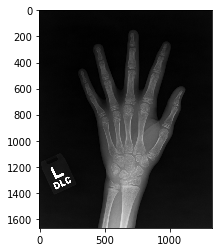

In [37]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [38]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [39]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [8]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They use 500x500 images.

In [40]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop, resize, horizontal and vertical translations

(534, 534, 3)

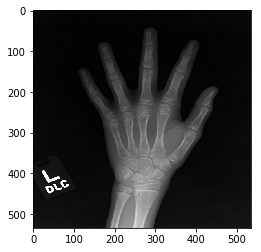

In [41]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
im = cv2.resize(im, (550, 550))
im = random_crop(im)
plt.imshow(im, cmap='gray')
im.shape

### Random Rotation (-10, 10) 

1.9983207024381389


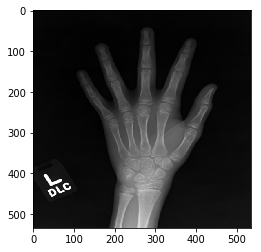

In [42]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

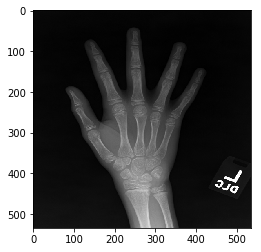

In [43]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [44]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

## Saving a resized dataset

In [45]:
# Do this to save time at training.
PATH_300 = PATH/"boneage-300"
#PATH_300.mkdir()

In [46]:
def get_a_crop(path, sz=300):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    pad = abs(r-c)//4
    if r > c :
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_REFLECT)
    else:
        im2 = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_REFLECT)
    return cv2.resize(center_crop(im2), (sz, sz))

In [47]:
from os import listdir
from os.path import join
def resize_all_images():
    for f in listdir(PATH/"boneage-training-dataset/"):
        old_path = join(PATH/"boneage-training-dataset/", f)
        new_path = join(PATH/"boneage-300/", f)
        img2 = get_a_crop(old_path)
        cv2.imwrite(new_path, img2)

In [17]:
#resize_all_images()

## Dataset

In [48]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

class BoneAgeDataset(Dataset):
    def __init__(self, df, transform=True, sz=300):
        self.path_to_images = PATH/"boneage-300/"
        self.transform = transform
        self.df = df
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x = cv2.imread(str(path)).astype(np.float32)/255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), y[None]

In [49]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transform=False)

In [50]:
x, y = train_ds[0]
x.shape, y.shape

((3, 284, 284), (1,))

In [51]:
x, y = valid_ds[0]
x.shape, y.shape

((3, 284, 284), (1,))

## Model

In [62]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Linear(512, 1)

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Finding optimal learning rate range
From this paper https://arxiv.org/pdf/1506.01186.pdf.
This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from `1e-5` to `0.012`.

In [58]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [59]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [60]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transform=False)
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=1)

In [63]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

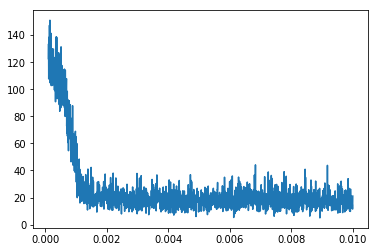

In [64]:
# first plot the whole graph
plt.plot(lrs, losses)
plt.show()

## Trainning with one cycle learning

Before training with this policy you have to estimate the range of learning rates using previous function.

In [65]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

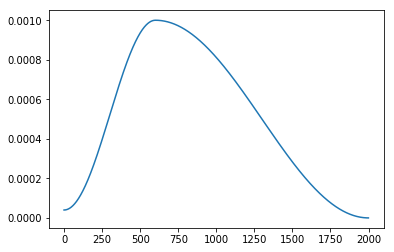

In [66]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [67]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/4, lr/2, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_resnet34_{1:.0f}.pth".format(PATH, 100*val_loss)
            if val_loss < 9:
                save_model(model, path)
                print(path)
    return sum_loss/total

In [68]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for x, y in valid_dl:
            batch = x.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            sum_loss += batch*(loss.item())
            total += batch
    return sum_loss/total

In [60]:
model = Net().cuda()
val_metric(model, valid_dl)

127.51635491706189

In [69]:
from datetime import datetime
start = datetime.now() 
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.005, epochs = 25)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of step", t)

train_loss 111.988 val_loss 88.241 

train_loss 50.781 val_loss 21.583 

train_loss 13.734 val_loss 12.777 

train_loss 12.623 val_loss 15.802 

train_loss 12.265 val_loss 24.370 

train_loss 12.132 val_loss 10.647 

train_loss 11.227 val_loss 10.315 

train_loss 11.064 val_loss 14.354 

train_loss 11.067 val_loss 14.372 

train_loss 11.097 val_loss 10.427 

train_loss 10.758 val_loss 19.302 

train_loss 10.497 val_loss 11.812 

train_loss 10.062 val_loss 12.101 

train_loss 10.265 val_loss 10.762 

train_loss 9.949 val_loss 10.427 

train_loss 9.617 val_loss 10.394 

train_loss 9.366 val_loss 11.229 

train_loss 9.214 val_loss 9.302 

train_loss 8.693 val_loss 9.028 

train_loss 8.720 val_loss 9.321 

train_loss 8.387 val_loss 9.413 

train_loss 8.130 val_loss 8.724 

/data2/yinterian/rsna-bone-age/models/model_resnet34_loss_872.pth
train_loss 7.925 val_loss 8.687 

/data2/yinterian/rsna-bone-age/models/model_resnet34_loss_869.pth
train_loss 7.883 val_loss 8.697 

train_loss 7.832 val

# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb